In [1]:
print('chat am i cooked ?')

chat am i cooked ?


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from scipy.optimize import minimize

In [3]:
# Seed generator from alphabetic string
def seed_gen(string):
    num_str = [ord(letter) - 96 for letter in string]
    # seed must be between 0 and 2**32 - 1
    return(np.mod(int(''.join(map(str,num_str))),2**32 - 1))

seeds = ['matterlab', 'beef', 'jakob', 'alan']

s = 0 # default seed, used in the main article results
np.random.seed(seed_gen(seeds[s])) 

In [4]:
num_qubits = 10
dev = qml.device("lightning.qubit", wires=num_qubits)

/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Ground state energy')

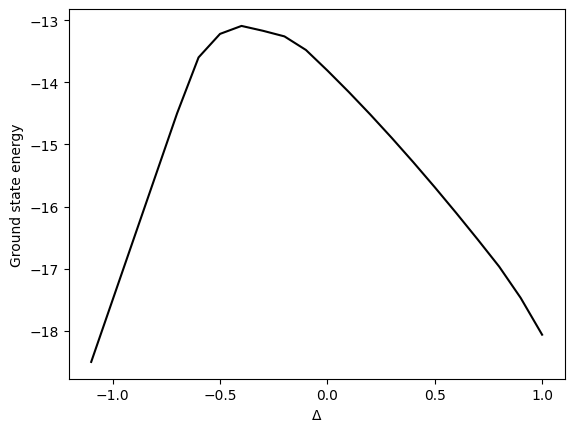

In [5]:
def spin_ham_XXZ(n, lam, delta):
    coeff = []
    operators = []

    # periodic boundary conditions (just so that it wraps around)
    operators.append(qml.PauliX(n-1) @ qml.PauliX(0))
    coeff.append(1.0)
    operators.append(qml.PauliY(n-1) @ qml.PauliY(0))
    coeff.append(1.0)
    operators.append(qml.PauliZ(n-1) @ qml.PauliZ(0))
    coeff.append(delta)

    for i in range(n-1):
        # XX coupling
        operators.append(qml.PauliX(i) @ qml.PauliX(i+1))
        coeff.append(1.0)

        # YY coupling
        operators.append(qml.PauliY(i) @ qml.PauliY(i+1))
        coeff.append(1.0)
        
        # ZZ coupling
        operators.append(qml.PauliZ(i) @ qml.PauliZ(i+1))
        coeff.append(delta)

    #transverse field
    for i in range(n):
        operators.append(qml.PauliZ(i))
        coeff.append(lam)
    return qml.Hamiltonian(coeff, operators)

# Function to compute the ground state energy
def ground_state(n, lam, delta):
    H = spin_ham_XXZ(n, lam, delta)
    H_matrix = qml.matrix(H, wire_order=list(range(n)))
    eigvals = np.linalg.eigvals(H_matrix)
    return min(eigvals)


exac = []
delta = np.arange(-1.1, 1.1, 0.1)
lam = 0.75
for d in delta:
    E0 = ground_state(n=num_qubits, delta=d, lam=lam)
    exac.append(E0)
plt.plot(delta, exac, label='Exact', color='black')
plt.xlabel('Δ')
plt.ylabel('Ground state energy')


In [6]:
# function to generate single qubit rotation gates
def single_rot(phi,theta, target):
    qml.RZ(phi, wires=target) 
    qml.RY(theta, wires=target)

In [7]:
# Function to generate encoding and processing layers
def processing_layer(proc_params, target, n, n_layers):
    for i in range(n_layers[0]):
        p = i % 2  #even/odd check
        for j in range(n):
            phi, theta = proc_params[i][j]
            single_rot(phi, theta, target[j])
        for j in range(p, n-1, 2):
            qml.CNOT(wires=[target[j], target[j+1]])

def encoding_layer(enc_params, w_params, delta, target, n, n_layers):
    for i in range(n_layers[1]):
        p = i % 2
        for j in range(n):
            phi, theta = enc_params[i][j]
            wth, wph = w_params[i][j]
            single_rot(wth * delta + phi, wph * delta + theta, target[j])
        for j in range(p, n - 1, 2):
            qml.CNOT(wires=[target[j], target[j + 1]])


<class 'numpy.ndarray'>
(<Figure size 1500x1100 with 1 Axes>, <Axes: >)


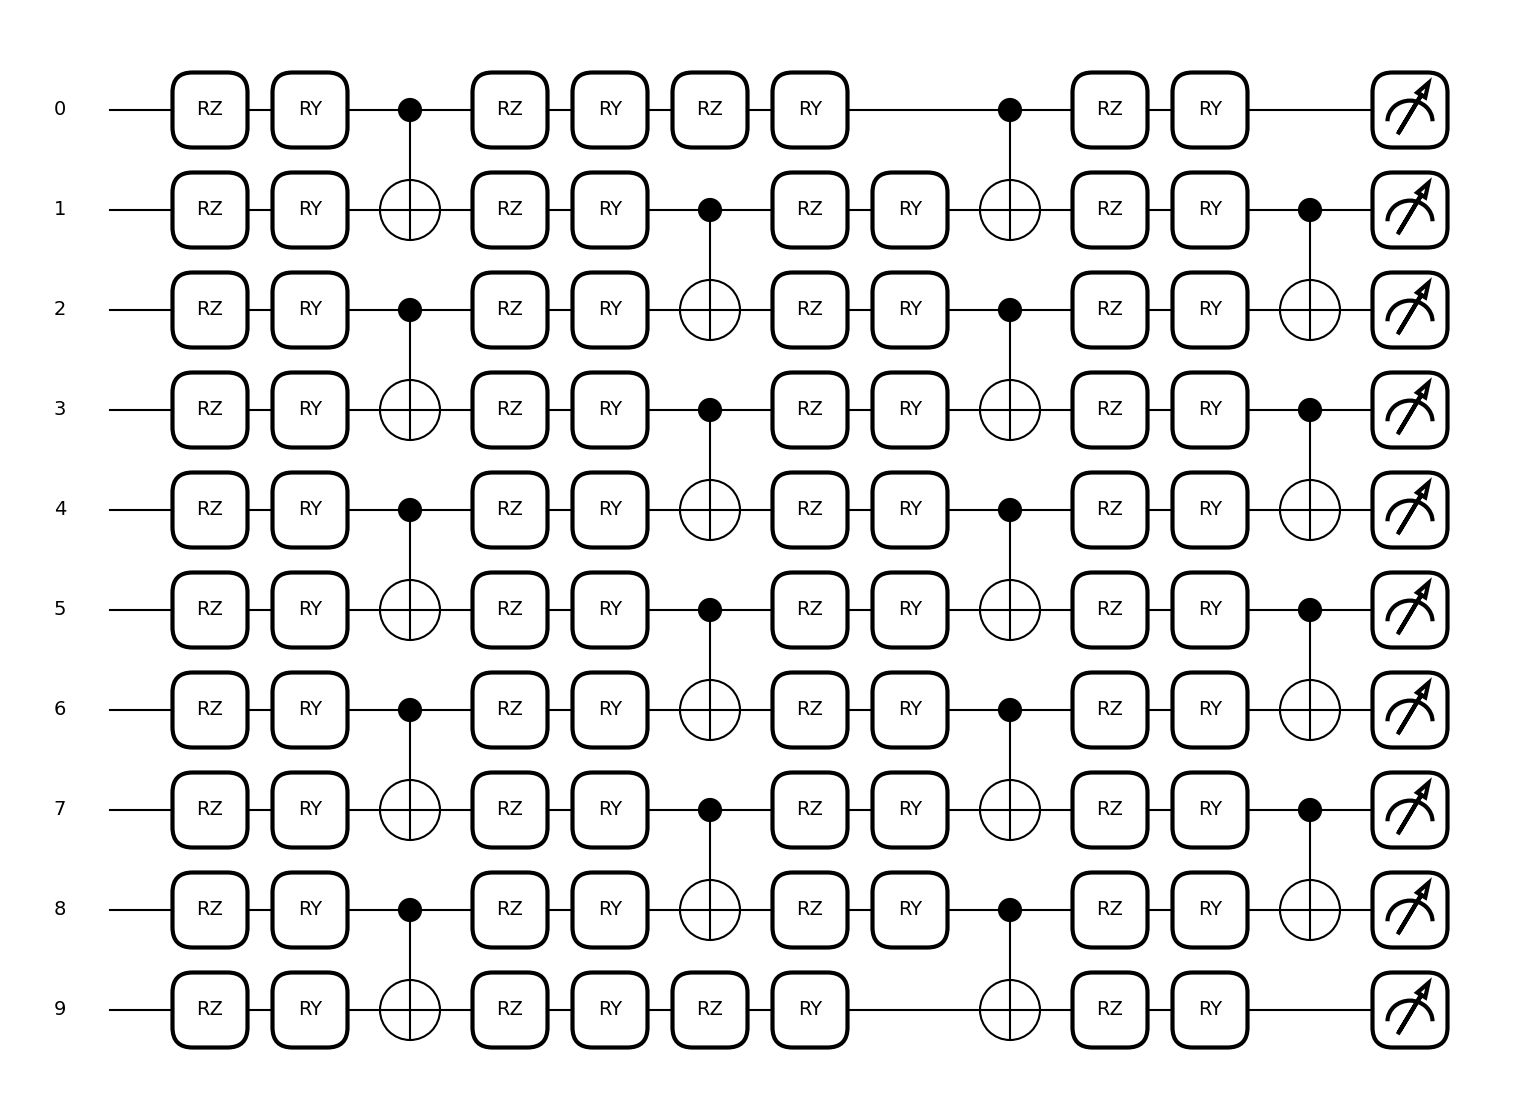

In [8]:
# Function to check if the ansatz circuit matches the one in the paper
@qml.qnode(dev)
def circuit(proc_params, enc_params, w_params, n, lam, delta, n_layers):
    ham = spin_ham_XXZ(n, lam, delta)
    # encoding layer
    encoding_layer(enc_params, w_params, delta, range(n), n, n_layers)
    # processing layer
    processing_layer(proc_params, range(n), n, n_layers)

    return qml.expval(ham)


num_layers = [2, 2] #processing, encoding

w_params = np.random.uniform(0, np.pi, (num_layers[1], num_qubits, 2)) 
proc_params = np.random.uniform(0, np.pi, (num_layers[0], num_qubits, 2))
enc_params = np.random.uniform(0, np.pi, (num_layers[1], num_qubits, 2))


print(type(proc_params))
drawer = qml.draw_mpl(circuit)
print(drawer(proc_params, enc_params, w_params, num_qubits, lam, 0.8, num_layers)) 


<class 'float'>
-1.7308480377049753


Text(0.5, 1.0, 'Expectation value of Hamiltonian vs Delta')

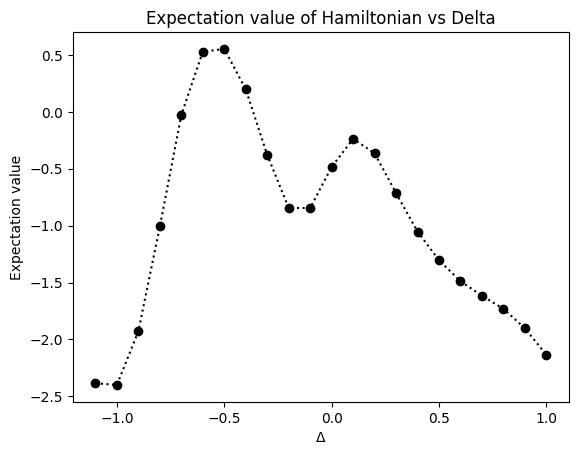

In [9]:
@qml.qnode(dev)
def expectation_value(proc_params,enc_params, w_params, n, lam, delta):
    
    ham = spin_ham_XXZ(n, lam, delta)
    # encoding layer
    encoding_layer(enc_params,w_params, delta, range(n), n, num_layers)
    # processing layer
    processing_layer(proc_params, range(n), n, num_layers)
    return qml.expval(ham)

# little check on the type of the output
exp_value = expectation_value(proc_params, enc_params, w_params, n=num_qubits, lam=lam, delta=0.8)
print(type(exp_value))
print(exp_value)

# compute the expectation value for different delta values in the range [-1.1, 1.1] defined above
exp_vals = []
for d in delta:
    exp_val = expectation_value(proc_params, enc_params, w_params, n=num_qubits, lam=lam, delta=d)
    exp_vals.append(exp_val)

   

plt.plot(delta, exp_vals, marker='o', linestyle=':', color='black')
plt.xlabel('Δ')
plt.ylabel('Expectation value')
plt.title('Expectation value of Hamiltonian vs Delta')

In [10]:
# initialize counters for number of circuit evaluations
meta_vqe_counter = 0
vqe_counter = 0
opt_meta_vqe_counter = 0

In [11]:
# generate circuit
@qml.qnode(dev, diff_method="finite-diff")
def meta_vqe_circuit(proc_params, enc_params, w_params, n, lam, delta, n_layers):
    global meta_vqe_counter
    meta_vqe_counter += 1

    # encoding layer
    encoding_layer(enc_params,w_params, delta, range(n), n, n_layers)
    # processing layer
    processing_layer(proc_params, range(n), n, n_layers)

    ham = spin_ham_XXZ(n, lam, delta)
    return qml.expval(ham)


def loss_function(proc_params, enc_params, w_params, n, lam, deltas):
    loss = 0
    for delta in deltas:
        loss += meta_vqe_circuit(proc_params, enc_params, w_params, n, lam, delta, num_layers)
    return loss/len(deltas)

In [12]:
# Generating the training set 
n_train = 20
n_test = 100

delta_min = 1.1
delta_max = -1.1
deltas_train = [delta_min + (delta_max - delta_min) * i / (n_train - 1) for i in range(n_train)]
lam = 0.75

#number of layers for each type of layer (same as before, just redefining it)
num_layers = [2,2] #processing, encoding

optimizer_method = 'BFGS'
tol = 1e-4


### Meta-VQE with BFGS optimizer

In [13]:
proc_params = np.random.uniform(0, np.pi, (num_layers[0],num_qubits, 2))
w_params = np.random.uniform(0, np.pi, (num_layers[1],num_qubits, 2))
enc_params = np.random.uniform(0, np.pi, (num_layers[1],num_qubits, 2))


#checking that the parameters are randomly initialized differently per qubit, per layer and per type of layer
print("proc parameters shape:", proc_params.shape)
print("sample enc param layer 0, qubit 0:", enc_params[0][0])
print("sample w param layer 1, qubit 2:", w_params[1][2])


proc parameters shape: (2, 10, 2)
sample enc param layer 0, qubit 0: [1.83058079 0.90111808]
sample w param layer 1, qubit 2: [2.09569834 0.46369917]


In [14]:
# we need to flatten the parameters to be able to use the minimize function
flat_params = np.concatenate([proc_params.flatten(), enc_params.flatten(), w_params.flatten()])

# Define shapes for reshaping later
proc_shape = proc_params.shape
enc_shape = enc_params.shape
w_shape = w_params.shape

proc_size = np.prod(proc_shape)
enc_size = np.prod(enc_shape)

losses = []

# Define the cost function
def cost_fn(flat_params):
    # Reshape flat_params back to original shapes
    
    proc_params_reshaped = flat_params[:proc_size].reshape(proc_shape)
    enc_params_reshaped = flat_params[proc_size:proc_size + enc_size].reshape(enc_shape)
    w_params_reshaped = flat_params[proc_size + enc_size:].reshape(w_shape)
    
    # Compute the loss
    loss = loss_function(proc_params_reshaped, enc_params_reshaped,
                          w_params_reshaped, num_qubits, lam, deltas_train)
    losses.append(loss)
    return loss


result = minimize(cost_fn, flat_params, method=optimizer_method, jac= '2-point',tol=tol, options={"maxiter": 100})

# Extract optimized parameters
optimized_flat_params = result.x
trained_proc_params = optimized_flat_params[:proc_size].reshape(proc_shape)
trained_enc_params = optimized_flat_params[proc_size:proc_size + enc_size].reshape(enc_shape)
trained_w_params = optimized_flat_params[proc_size + enc_size:].reshape(w_shape)

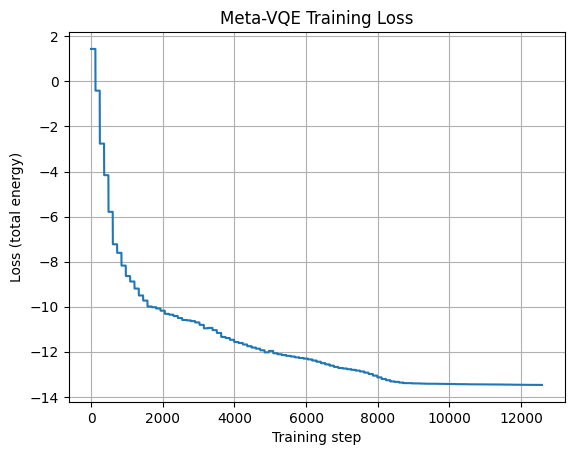

In [15]:
plt.plot(losses)
plt.xlabel("Training step")
plt.ylabel("Loss (total energy)")
plt.title("Meta-VQE Training Loss")
plt.grid()
plt.show()

In [16]:
print("Meta-VQE circuit evaluations:", meta_vqe_counter)
print("Standard VQE circuit evaluations:", vqe_counter)
print("Opt-Meta-VQE circuit evaluations:", opt_meta_vqe_counter)

Meta-VQE circuit evaluations: 251680
Standard VQE circuit evaluations: 0
Opt-Meta-VQE circuit evaluations: 0


In [17]:
delta_sample = 0.8

before = meta_vqe_circuit(proc_params, enc_params, w_params, num_qubits, lam, delta_sample, num_layers)
after  = meta_vqe_circuit(trained_proc_params, trained_enc_params, 
                          trained_w_params, num_qubits, lam, delta_sample, num_layers)

print("Before training:", before)
print("After training:", after)

meta_vqe_counter -= 2 #get rid of the two evaluations of the circuit

Before training: 3.6842597574382894
After training: -14.557360827690328


In [18]:
x_train = deltas_train 
y_train_ex = []
y_train_metaVQE = []
error_train_metaVQE = []

# Loop over all training points
for delta in deltas_train:
    # Use trained parameters to evaluate the circuit
    pred_energy = meta_vqe_circuit(trained_proc_params, trained_enc_params,
                                    trained_w_params, num_qubits, lam, delta, num_layers)

    # Reference exact solution 
    true_energy = ground_state(num_qubits, lam, delta)

    # print(delta, true_energy, pred_energy, abs(pred_energy-true_energy))
    # Store results
    y_train_metaVQE.append(pred_energy)
    y_train_ex.append(true_energy)
    error_train_metaVQE.append(abs(pred_energy - true_energy))
    print(delta, true_energy, pred_energy, abs(pred_energy-true_energy))

meta_vqe_counter -= n_train #get rid of the evaluations of the circuit for the training set

1.1 (-18.672905457259564+0j) -15.606804389630602 3.0661010676289617
0.9842105263157895 (-17.966948856603864-4.453764112279252e-30j) -15.294315817834871 2.6726330387689927
0.868421052631579 (-17.285228897437364-1.872262680089326e-30j) -14.71014710756747 2.575081789869893
0.7526315789473685 (-16.757848320622447-3.155443620885846e-30j) -14.517600116082955 2.2402482045394922
0.6368421052631579 (-16.25889319255855-6.409478855350645e-31j) -14.302308442287377 1.9565847502711726
0.5210526315789474 (-15.77480118331716+1.5777218104420175e-30j) -13.582348932875743 2.192452250441418
0.4052631578947369 (-15.306661156303175+2.6021058736548906e-30j) -12.739116787908065 2.56754436839511
0.2894736842105263 (-14.855609048356715-6.318115904858059e-30j) -12.364695004087679 2.4909140442690365
0.17368421052631577 (-14.422835602700635+3.155443620884042e-30j) -12.265778345021682 2.1570572576789537
0.05789473684210522 (-14.009602573162853+3.062120541337195e-30j) -11.878596468021849 2.1310061051410045
-0.057894

In [19]:
deltas_test = [np.random.uniform(delta_min, delta_max) for _ in range(n_test)]
deltas_test.sort()

x_test = deltas_test
y_test_ex = []
y_test_metaVQE = []
error_test_metaVQE = []

# Inference on test points
for delta in x_test:
    pred_energy = meta_vqe_circuit(trained_proc_params, trained_enc_params, 
                                   trained_w_params, num_qubits, lam, delta, num_layers)
    exact_energy = ground_state(num_qubits, lam, delta) 

    y_test_metaVQE.append(pred_energy)
    y_test_ex.append(exact_energy)
    error_test_metaVQE.append(abs(pred_energy - exact_energy))
    # print(delta, exact_energy, pred_energy, abs(pred_energy - exact_energy))


meta_vqe_counter -= n_test #get rid of the 200 evaluations from the testing


/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


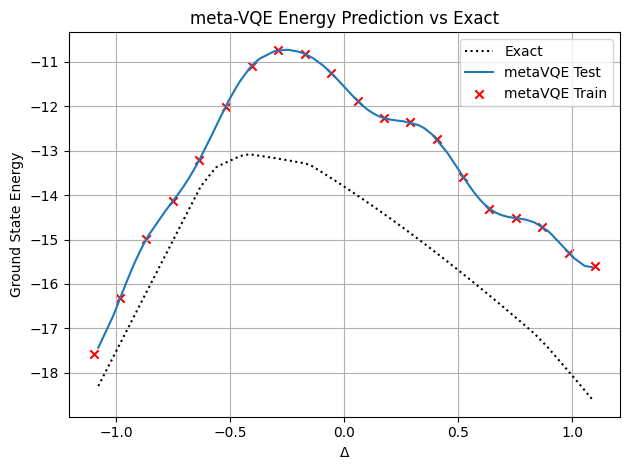

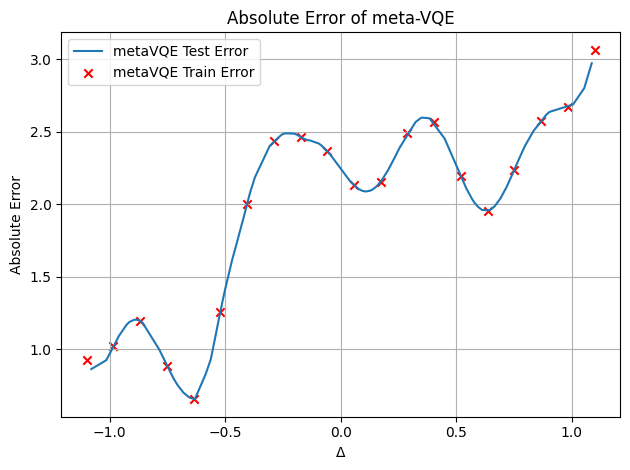

In [20]:
# Ground state energy plot
plt.plot(x_test, y_test_ex, color="black", linestyle=":", label="Exact")
plt.plot(x_test, y_test_metaVQE, linestyle="-", label="metaVQE Test")
plt.scatter(x_train, y_train_metaVQE, color="red", marker="x", label="metaVQE Train")
plt.xlabel(r"$\Delta$")
plt.ylabel("Ground State Energy")
plt.title("meta-VQE Energy Prediction vs Exact")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Absolute error plot
plt.plot(x_test, error_test_metaVQE, linestyle="-", label="metaVQE Test Error")
plt.scatter(x_train, error_train_metaVQE, color="red", marker="x", label="metaVQE Train Error")
plt.xlabel(r"$\Delta$")
plt.ylabel("Absolute Error")
plt.title("Absolute Error of meta-VQE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
print("Meta-VQE circuit evaluations:", meta_vqe_counter)
print("Standard VQE circuit evaluations:", vqe_counter)
print("Opt-Meta-VQE circuit evaluations:", opt_meta_vqe_counter)

Meta-VQE circuit evaluations: 251680
Standard VQE circuit evaluations: 0
Opt-Meta-VQE circuit evaluations: 0


### Standard VQE

In [22]:
vqe_num_layers = [num_layers[0]+ num_layers[1], 0] #vqe only has processing layers

In [23]:
# the main difference between VQE and meta-VQE is that all layers are equivalent to processing layers
@qml.qnode(dev, diff_method="finite-diff")
def vqe_circuit(proc_params, n, lam, delta):
    global vqe_counter
    vqe_counter += 1

    processing_layer(proc_params, range(n), n, vqe_num_layers)
    ham = spin_ham_XXZ(n, lam, delta)
    return qml.expval(ham)

In [24]:
losses = []
y_VQE = []
error_yVQE = []

# Define the cost function for each delta value
def cost_fn(params, delta):
    params_reshaped = params.reshape(vqe_proc_shape)
    return vqe_circuit(params_reshaped, num_qubits, lam, delta)

for i in range(n_train):
    delta = deltas_train[i]

    proc_params = np.random.uniform(0, np.pi, (num_layers[0]+ num_layers[1],num_qubits, 2))
    vqe_proc_shape = proc_params.shape
    vqe_flat_params = proc_params.flatten()
    
    vqe_proc_size = np.prod(vqe_proc_shape)
    
    # Create a closure for this specific delta
    objective = lambda p: cost_fn(p, delta)
    
    # Optimize
    result = minimize(objective, vqe_flat_params, method=optimizer_method, 
                     jac='2-point',tol=tol, options={"maxiter": 100})
    
    # Store results
    loss = cost_fn(result.x, delta)
    losses.append(loss)
    y_VQE.append(loss)
    error_yVQE.append(abs(loss - y_train_ex[i]))
    
    print(deltas_train[i], y_train_ex[i], loss, abs(loss - y_train_ex[i]))

1.1 (-18.672905457259564+0j) -16.926374759061453 1.7465306981981108
0.9842105263157895 (-17.966948856603864-4.453764112279252e-30j) -16.268571884937156 1.6983769716667076
0.868421052631579 (-17.285228897437364-1.872262680089326e-30j) -15.886920724604506 1.3983081728328575
0.7526315789473685 (-16.757848320622447-3.155443620885846e-30j) -15.403530304198735 1.3543180164237114
0.6368421052631579 (-16.25889319255855-6.409478855350645e-31j) -14.937188405439478 1.3217047871190708
0.5210526315789474 (-15.77480118331716+1.5777218104420175e-30j) -14.32254090387049 1.452260279446671
0.4052631578947369 (-15.306661156303175+2.6021058736548906e-30j) -13.951694035435816 1.354967120867359
0.2894736842105263 (-14.855609048356715-6.318115904858059e-30j) -13.64154416905485 1.2140648793018656
0.17368421052631577 (-14.422835602700635+3.155443620884042e-30j) -13.246957618077358 1.175877984623277
0.05789473684210522 (-14.009602573162853+3.062120541337195e-30j) -12.978181490925932 1.0314210822369212
-0.057894

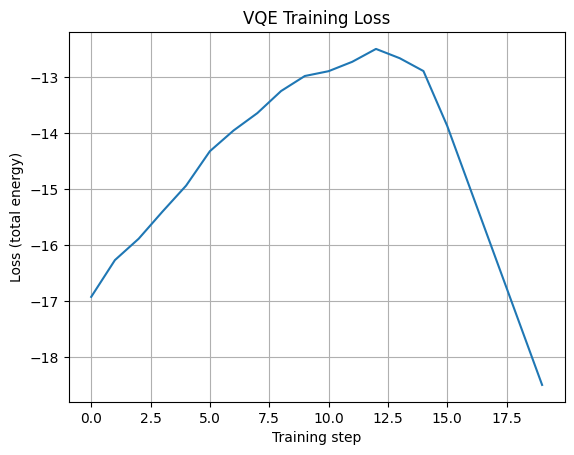

In [25]:
plt.plot(losses)
plt.xlabel("Training step")
plt.ylabel("Loss (total energy)")
plt.title("VQE Training Loss")
plt.grid()
plt.show()

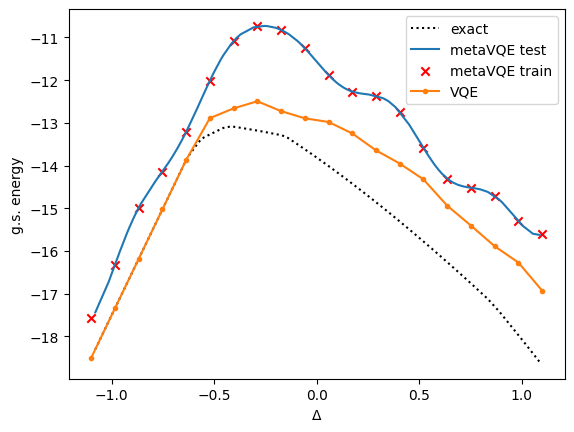

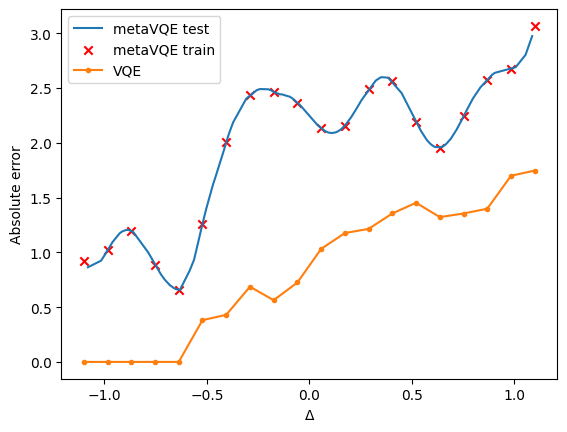

In [26]:
plt.plot(x_test, y_test_ex, color="black", ls=":", label="exact")
plt.plot(x_test, y_test_metaVQE,  ls="-", label="metaVQE test")
plt.scatter(x_train, y_train_metaVQE, color="red", marker="x", label="metaVQE train")
plt.plot(x_train, y_VQE,  marker=".", label="VQE")
plt.xlabel("Δ")
plt.ylabel('g.s. energy')
plt.legend()
plt.show()


plt.plot(x_test, error_test_metaVQE, ls="-", label="metaVQE test")
plt.scatter(x_train, error_train_metaVQE, marker="x", color="red", label="metaVQE train")
plt.plot(x_train, error_yVQE, marker=".", label="VQE")
plt.xlabel("Δ")
plt.ylabel("Absolute error")
plt.legend()
plt.show()



In [27]:
print("Meta-VQE circuit evaluations:", meta_vqe_counter)
print("Standard VQE circuit evaluations:", vqe_counter)
print("Opt-Meta-VQE circuit evaluations:", opt_meta_vqe_counter)

Meta-VQE circuit evaluations: 251680
Standard VQE circuit evaluations: 155621
Opt-Meta-VQE circuit evaluations: 0


### OPT-meta-VQE

In [28]:
@qml.qnode(dev, diff_method="finite-diff")
def opt_meta_vqe_circuit(proc_params, enc_params, w_params, n, lam, delta, n_layers):
    global opt_meta_vqe_counter
    opt_meta_vqe_counter += 1

    # encoding layer
    encoding_layer(enc_params,w_params, delta, range(n), n, n_layers)
    # processing layer
    processing_layer(proc_params, range(n), n, n_layers)

    ham = spin_ham_XXZ(n, lam, delta)
    return qml.expval(ham)

In [29]:
# Initialize the parameters
opt_proc_params = trained_proc_params.copy()
opt_enc_params = trained_enc_params.copy()
opt_w_params = trained_w_params.copy()

In [30]:
opt_flat_params = np.concatenate([opt_proc_params.flatten(), opt_enc_params.flatten(), opt_w_params.flatten()])

# Define shapes for reshaping later
proc_shape = opt_proc_params.shape
enc_shape = opt_enc_params.shape
w_shape = opt_w_params.shape

proc_size = np.prod(proc_shape)
enc_size = np.prod(enc_shape)

In [31]:
y_opt_metaVQE = []
error_y_opt_metaVQE = []

# Define the cost function
def opt_cost_fn(flat_params, delta):
    # Reshape flat_params back to original shapes
    
    proc_params_reshaped = flat_params[:proc_size].reshape(proc_shape)
    enc_params_reshaped = flat_params[proc_size:proc_size + enc_size].reshape(enc_shape)
    w_params_reshaped = flat_params[proc_size + enc_size:].reshape(w_shape)
    
    return opt_meta_vqe_circuit(proc_params_reshaped, enc_params_reshaped, 
                                w_params_reshaped, num_qubits, lam, delta, num_layers)

for i in range(n_train):
    delta = deltas_train[i]
    
    # Create a closure for this specific delta
    opt_objective = lambda opt_flat_params: opt_cost_fn(opt_flat_params, delta)
    
    # Optimize
    opt_result = minimize(opt_objective, opt_flat_params, method=optimizer_method, 
                     jac='2-point', tol= tol, options={"maxiter": 100})
    
    # Store results
    opt_loss = opt_cost_fn(opt_result.x, delta)
    y_opt_metaVQE.append(opt_loss)
    error_y_opt_metaVQE.append(abs(opt_loss - y_train_ex[i]))
    
    print(deltas_train[i], y_train_ex[i], opt_loss, abs(opt_loss - y_train_ex[i]))


1.1 (-18.672905457259564+0j) -16.984704283289954 1.6882011739696097
0.9842105263157895 (-17.966948856603864-4.453764112279252e-30j) -16.44190795414821 1.525040902455654
0.868421052631579 (-17.285228897437364-1.872262680089326e-30j) -15.923320603377666 1.3619082940596972
0.7526315789473685 (-16.757848320622447-3.155443620885846e-30j) -15.428639413762863 1.3292089068595843
0.6368421052631579 (-16.25889319255855-6.409478855350645e-31j) -14.939032274343393 1.3198609182151557
0.5210526315789474 (-15.77480118331716+1.5777218104420175e-30j) -14.521799513675054 1.2530016696421065
0.4052631578947369 (-15.306661156303175+2.6021058736548906e-30j) -14.110147579871347 1.196513576431828
0.2894736842105263 (-14.855609048356715-6.318115904858059e-30j) -13.743078674978586 1.1125303733781298
0.17368421052631577 (-14.422835602700635+3.155443620884042e-30j) -13.4100768364339 1.0127587662667352
0.05789473684210522 (-14.009602573162853+3.062120541337195e-30j) -13.119320180758795 0.8902823924040586
-0.057894

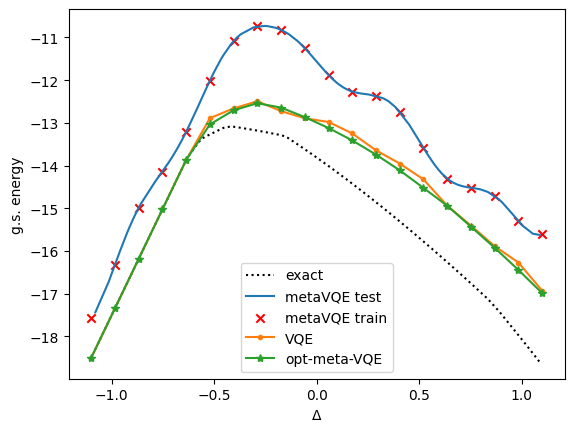

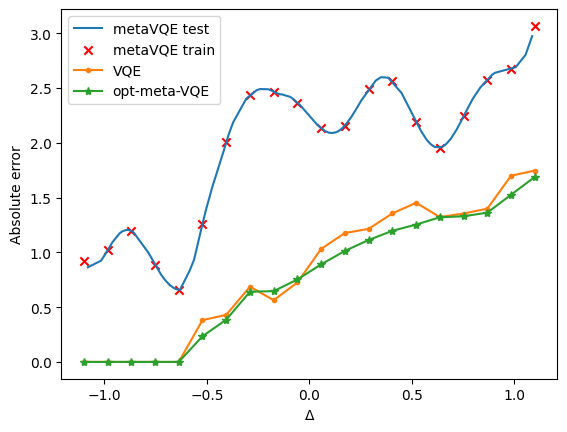

In [32]:
plt.plot(x_test, y_test_ex, color="black", ls=":", label="exact")
plt.plot(x_test, y_test_metaVQE,  ls="-", label="metaVQE test")
plt.scatter(x_train, y_train_metaVQE, color="red", marker="x", label="metaVQE train")
plt.plot(x_train, y_VQE,  marker=".", label="VQE")
plt.plot(x_train, y_opt_metaVQE, marker="*", label="opt-meta-VQE")


plt.xlabel("Δ")
plt.ylabel('g.s. energy')
plt.legend()

plt.show()

# Absolute error

plt.plot(x_test, error_test_metaVQE, ls="-", label="metaVQE test")
plt.scatter(x_train, error_train_metaVQE, marker="x", color="red", label="metaVQE train")
plt.plot(x_train, error_yVQE, marker=".", label="VQE")
plt.plot(x_train, error_y_opt_metaVQE, marker="*", label="opt-meta-VQE")


plt.xlabel("Δ")
plt.ylabel("Absolute error")
plt.legend()
plt.show()



In [33]:
print("Meta-VQE circuit evaluations:", meta_vqe_counter)
print("Standard VQE circuit evaluations:", vqe_counter)
print("Opt-Meta-VQE circuit evaluations:", opt_meta_vqe_counter)

Meta-VQE circuit evaluations: 251680
Standard VQE circuit evaluations: 155621
Opt-Meta-VQE circuit evaluations: 210197


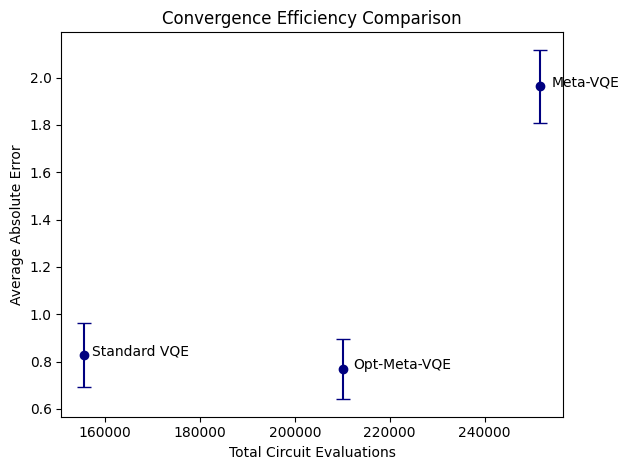

In [34]:
methods = ['Meta-VQE', 'Standard VQE', 'Opt-Meta-VQE']
circuit_counts = [meta_vqe_counter, vqe_counter, opt_meta_vqe_counter]
errors = [np.mean(error_train_metaVQE), np.mean(error_yVQE), np.mean(error_y_opt_metaVQE)]
error_bars = [
    np.std(error_train_metaVQE) / np.sqrt(len(error_train_metaVQE)),
    np.std(error_yVQE) / np.sqrt(len(error_yVQE)),
    np.std(error_y_opt_metaVQE) / np.sqrt(len(error_y_opt_metaVQE))]


plt.errorbar(circuit_counts, errors, yerr=error_bars, fmt='o', color='navy', capsize=5)

for i, method in enumerate(methods):
    plt.text(circuit_counts[i] * 1.01, errors[i], method, fontsize=10)
plt.xlabel("Total Circuit Evaluations")
plt.ylabel("Average Absolute Error")
plt.title("Convergence Efficiency Comparison")
plt.tight_layout()
plt.show()

In [35]:
print("Convergence Analysis:")
print(f"Meta-VQE     : {meta_vqe_counter} circuits for {n_train} deltas → Avg error: {np.mean(error_train_metaVQE):.4f}")
print(f"Standard VQE : {vqe_counter} total circuits ({vqe_counter // n_train} per delta) → Avg error: {np.mean(error_yVQE):.4f}")
print(f"Opt-Meta-VQE : {opt_meta_vqe_counter} circuits for {n_train} deltas → Avg error: {np.mean(error_y_opt_metaVQE):.4f}")


Convergence Analysis:
Meta-VQE     : 251680 circuits for 20 deltas → Avg error: 1.9633
Standard VQE : 155621 total circuits (7781 per delta) → Avg error: 0.8267
Opt-Meta-VQE : 210197 circuits for 20 deltas → Avg error: 0.7674
